In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv("./datas/test_plan_featrues.csv")

In [3]:
print(df.shape)
df.head()

(5, 6)


,planId,tagList,locationList,durationDays,locationRatingAvg,likeCount
0,2,4 5 6 7,"1(1, 2, 3), 10(2, 3, 8), 3(3, 5), 4(2, 3, 6, 7...",3,4.512500,0
1,3,8 9 10 11,"12(1, 2, 3), 14(2, 3, 12, 13), 17(2, 3, 6, 7, ...",4,4.200000,4
2,4,7 12 13 14,"1(1, 2, 3), 58(1, 2, 3), 59(2, 3), 60(2, 3, 26...",30,4.485714,1
3,5,1 2 15 16 17 18,"27(1, 2, 3), 28(2, 3, 4), 29(16, 22), 30(23), ...",9,4.415000,0
4,6,19 20 21 22 23,"100(16, 35), 71(1, 2, 3), 72(2, 3, 4), 73(2, 3...",7,4.438461,10


In [4]:
# 🔹 tagList: Multi-label One-hot Encoding
df['tagList'] = df['tagList'].astype(str).apply(lambda x: list(map(int, x.strip().split())))
mlb_tag = MultiLabelBinarizer()
tag_encoded = mlb_tag.fit_transform(df['tagList'])

In [5]:
# 🔹 locationList: locationId 추출 → One-hot Encoding
def extract_location_ids(text):
    location_ids = []
    if pd.notna(text):
        pairs = text.split(', ')
        for pair in pairs:
            try:
                loc_id = int(pair.split('(')[0])
                location_ids.append(loc_id)
            except:
                continue
    return location_ids

# 🔹 locationList: typeId 추출 → One-hot Encoding
def extract_type_ids(text):
    type_ids = []
    if pd.notna(text):
        pairs = text.split(', ')
        for pair in pairs:
            try:
                type_text = pair.split('(')[1].replace(')', '')
                type_ids.extend(map(int, type_text.split(', ')))
            except:
                continue
    return list(set(type_ids))  # 중복 제거


In [6]:
df['locationIds'] = df['locationList'].apply(extract_location_ids)
mlb_loc = MultiLabelBinarizer()
location_encoded = mlb_loc.fit_transform(df['locationIds'])

In [7]:
df['typeIds'] = df['locationList'].apply(extract_type_ids)
mlb_type = MultiLabelBinarizer()
type_encoded = mlb_type.fit_transform(df['typeIds'])

In [8]:
# 🔹 durationDays, locationRatingAvg → Min-Max 정규화
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(df[['durationDays', 'locationRatingAvg']])

In [9]:
# 🔹 벡터 최종 결합
final_vectors = np.concatenate([
    tag_encoded,
    location_encoded,
    type_encoded,
    numeric_features
], axis=1)

In [10]:
# 🔹 결과 DataFrame 생성 (planId 포함)
vector_df = pd.DataFrame(final_vectors)
vector_df.insert(0, 'planId', df['planId'])

In [11]:
# 🔹 확인
print(vector_df.head())

   planId    0    1    2    3    4    5    6    7    8  ...  106  107  108  \
0       2  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
1       3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  ...  0.0  0.0  1.0   
2       4  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
3       5  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
4       6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0   

   109  110  111  112  113       114       115  
0  1.0  1.0  0.0  0.0  0.0  0.000000  1.000000  
1  1.0  0.0  0.0  0.0  0.0  0.037037  0.000000  
2  1.0  1.0  1.0  0.0  0.0  1.000000  0.914286  
3  1.0  0.0  1.0  1.0  0.0  0.222222  0.688000  
4  1.0  1.0  1.0  0.0  1.0  0.148148  0.763076  

[5 rows x 117 columns]


In [12]:
# 🔸 PCA로 2차원 축소
pca = PCA(n_components=2)
vector_2d_pca = pca.fit_transform(final_vectors)

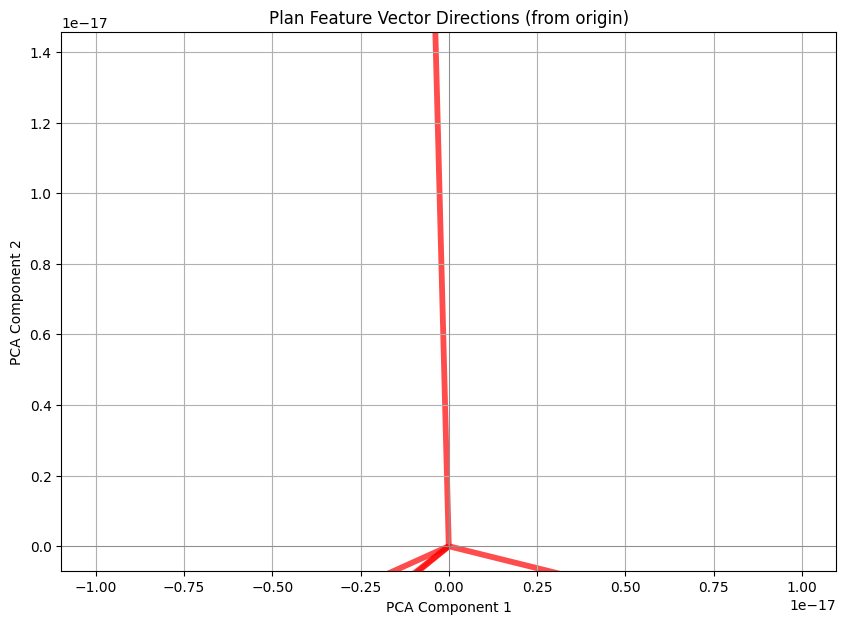

In [13]:
# 🔸 원점 기준 화살표 (quiver)
plt.figure(figsize=(10, 7))
plt.quiver(
    np.zeros(len(vector_2d_pca)),  # 원점 X
    np.zeros(len(vector_2d_pca)),  # 원점 Y
    vector_2d_pca[:, 0],           # 방향 X
    vector_2d_pca[:, 1],           # 방향 Y
    angles='xy', scale_units='xy', scale=1,
    color='red', alpha=0.7
)

# 🔸 planId 표시
for i, plan_id in enumerate(df['planId']):
    plt.text(vector_2d_pca[i, 0], vector_2d_pca[i, 1], str(plan_id), fontsize=9)

plt.title("Plan Feature Vector Directions (from origin)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(True)
plt.axis('equal')
plt.show()

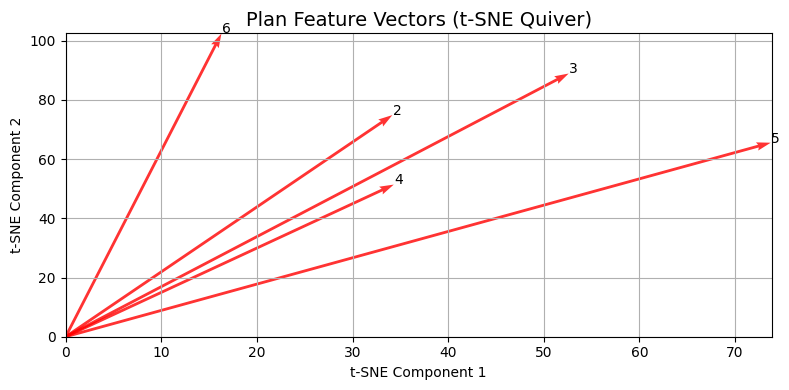

Plan 2: End point at (34.17, 74.88)
Plan 3: End point at (52.61, 88.92)
Plan 4: End point at (34.31, 51.39)
Plan 5: End point at (73.73, 65.54)
Plan 6: End point at (16.29, 102.40)


In [36]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
vector_2d_tsne = tsne.fit_transform(final_vectors)

# 벡터 구성
u = vector_2d_tsne[:, 0]
v = vector_2d_tsne[:, 1]
start_x = np.zeros(len(u))
start_y = np.zeros(len(v))

# ✅ x, y 축 최대값 구해서 꼭짓점 안 잘리게
margin = 0.1  # 살짝 여유 공간
x_max = u.max() + margin
y_max = v.max() + margin
x_min = min(0, u.min() - margin)  # 만약 음수 방향도 있으면 보여주기

# 시각화
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 화살표 그리기
ax.quiver(
    start_x, start_y, u, v,
    angles='xy', scale_units='xy', scale=1,
    color='red', alpha=0.8, width=0.004
)

# planId 표시 (원하는 경우 주석 해제)
for i, plan_id in enumerate(df['planId']):
    ax.text(u[i] + 0.05, v[i] + 0.05, str(plan_id), fontsize=10)

# ✅ 꼭짓점까지 축 범위 설정
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, y_max)

ax.set_title('Plan Feature Vectors (t-SNE Quiver)', fontsize=14)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.grid(True)
plt.tight_layout()
plt.show()

# 벡터 꼭짓점 좌표 출력
for i in range(len(u)):
    print(f'Plan {df['planId'][i]}: End point at ({u[i]:.2f}, {v[i]:.2f})')


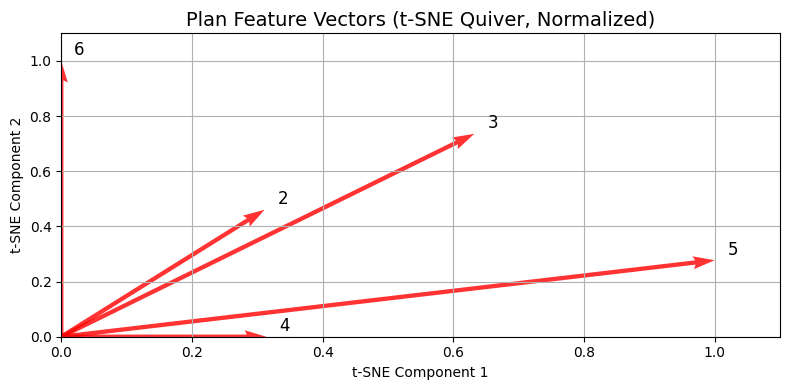

Plan 2: End point at (0.31, 0.46)
Plan 3: End point at (0.63, 0.74)
Plan 4: End point at (0.31, 0.00)
Plan 5: End point at (1.00, 0.28)
Plan 6: End point at (0.00, 1.00)


In [35]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
vector_2d_tsne = tsne.fit_transform(final_vectors)

# 🎯 정규화 (0~1 범위로)
scaler = MinMaxScaler()
vector_2d_norm = scaler.fit_transform(vector_2d_tsne)

# 벡터 구성
u = vector_2d_norm[:, 0]
v = vector_2d_norm[:, 1]
start_x = np.zeros(len(u))
start_y = np.zeros(len(v))

# 시각화
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 화살표 그리기
ax.quiver(
    start_x, start_y, u, v,
    angles='xy', scale_units='xy', scale=1,
    color='red', alpha=0.8, width=0.006
)

# planId 표시
for i, plan_id in enumerate(df['planId']):
    ax.text(u[i] + 0.02, v[i] + 0.02, str(plan_id), fontsize=12)

# 축 범위
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)

ax.set_title('Plan Feature Vectors (t-SNE Quiver, Normalized)', fontsize=14)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.grid(True)

plt.tight_layout()
plt.show()

# 벡터 꼭짓점 확인
for i in range(len(u)):
    print(f'Plan {df['planId'][i]}: End point at ({u[i]:.2f}, {v[i]:.2f})')